# Head Pose Estimation - Pan

In [1]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
tf.keras.optimizers.RMSprop
%matplotlib inline
import os
tf.__version__

Using TensorFlow backend.


'2.1.0'

In [2]:
#upload and unzip data file
import zipfile
with zipfile.ZipFile('./modified_data.zip', 'r') as zip_ref:
 zip_ref.extractall('./')

In [3]:
#Reading training data
train = pd.read_csv("./train_data.csv")
#understand shape of dataframe
train.head()

,filename,person_id,series,tilt,pan
0,face_790.jpg,5,1,-15,30
1,face_2445.jpg,5,1,0,-75
2,face_2266.jpg,5,2,-15,-60
3,face_2713.jpg,5,2,0,-90
4,face_2016.jpg,5,2,15,-75


## Understand Data and Preprocessing
Checking shape of training data and creating a plot to analyse Bias in data

In [4]:
train.shape

(2325, 5)

In [5]:
#grouping
shape_data_group= train.groupby(["pan"])
shape_data_group_plot= shape_data_group.count()

,filename,person_id,series,tilt
pan,,,,
-90,175,175,175,175
-75,175,175,175,175
-60,175,175,175,175
-45,175,175,175,175
-30,175,175,175,175
-15,175,175,175,175
0,225,225,225,225
15,175,175,175,175
30,175,175,175,175


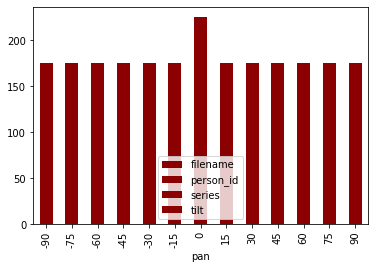

In [6]:
#plotting bar chart
shape_data_group_plot.plot(kind='bar',color=('darkred'))
shape_data_group.count()

In [7]:
train['pan'] = train['pan'].astype(str)

In [8]:
#Splitting Data into TRAIN, TEST AND VALIDATION
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(train,test_size = 0.2)
training_data, validation_data = train_test_split(train_data,test_size = 0.2)

# Generate two data frames for training and validation #
print('Train size: {}, Test size: {}'.format(training_data.shape[0], validation_data.shape[0] ) ) 
N_train_images = training_data.shape[0]
N_val_images = validation_data.shape[0]

Train size: 1488, Test size: 372


In [9]:
training_data.shape

(1488, 5)

In [10]:
validation_data.shape

(372, 5)

Inspecting the Data images in a random order

In [11]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('modified_data/*.jpg', recursive=True): #assuming gif
    headpose = filepath.split("/")[1]
    image_list.append((filepath, headpose))
headpose_data = pd.DataFrame(data=image_list, columns=['image_path', 'filename'])

In [12]:
import cv2
import os

for filepath in glob.glob('modified_data/*.jpg', recursive=True):
    
    img = cv2.imread(filepath)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(filepath), gray)

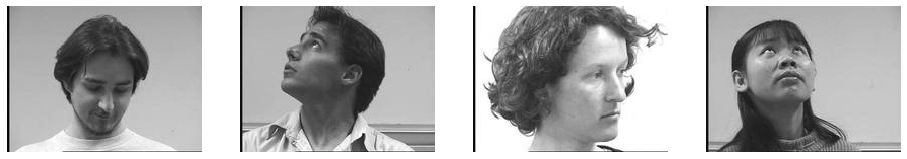

In [13]:
r_inx = np.random.choice(100, 4)
rand_data = headpose_data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

## Loading Function

we are using rmsprop and categorical_crossentropy snce there are more than two categories in the output variable.The dataset is complicated hence we will be loading them in batches, and batch size is chosen as 16. The loading function converts channels into 3-channel images. Data normalization is done to bring it in pixel [0-1] value

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_data,
    directory='./modified_data', 
    x_col="filename", 
    y_col="pan", 
    target_size=(32, 32), 
    batch_size=batch_size, 
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory='./modified_data', 
    x_col="filename", 
    y_col="pan", 
    target_size=(32, 32), 
    batch_size=batch_size, 
    class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./modified_data',
        x_col="filename",
        y_col="pan",
        target_size=(32, 32),
        shuffle = False,
        batch_size=batch_size,
        class_mode='categorical')

Found 1488 validated image filenames belonging to 13 classes.
Found 372 validated image filenames belonging to 13 classes.
Found 465 validated image filenames belonging to 13 classes.


## Training model 

In [15]:
#function to train a model train the model
def train_model(model_, num_epoch=100, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

## Accuracy and Loss Function

In [16]:
def calculate_losses(model_, data_generator_, N_images, batch_size_): 
    loss_hold = []
    acc_hold = []
    batches = 0
    for x,y in data_generator_:
        loss,acc = model_.evaluate(x, y, verbose=0) 
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because 
            # the generator loops indefinitely
            break
        
    return np.mean(loss_hold), np.mean(acc_hold)

In [17]:
N_train_images = 1488
N_val_images = 372

## Model 1

Using sequantial modelling

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model1 = Sequential()

# input
model1.add(Input(shape=(32, 32, 3)))
model1.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model1.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model1.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model1.add(Activation('relu'))

# Conv Layer 3
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model1.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model1.add(Dense(64))
model1.add(Activation('relu'))
model1.add(Dropout(0.5))
model1.add(Dense(13))
model1.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model1.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
model1.save_weights('model.h5')

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        320       
_________________________________________________________________
activation (Activation)      (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 11, 11, 64)        1

In [19]:
#training the model1
res = train_model(model1, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.5984580516815186, Accuracy = 0.07712765783071518
Validation epoch 0: Loss = 2.597330013910929, Accuracy = 0.09166666865348816
Training epoch 1: Loss = 2.597020149230957, Accuracy = 0.09328968822956085
Validation epoch 1: Loss = 2.5941036144892373, Accuracy = 0.09166666865348816
Training epoch 2: Loss = 2.5922205448150635, Accuracy = 0.10177986323833466
Validation epoch 2: Loss = 2.5891289710998535, Accuracy = 0.09322916716337204
Training epoch 3: Loss = 2.588634490966797, Accuracy = 0.102853924036026
Validation epoch 3: Loss = 2.58800599972407, Accuracy = 0.09166666865348816
Training epoch 4: Loss = 2.5792741775512695, Accuracy = 0.10310965031385422
Validation epoch 4: Loss = 2.5761303504308066, Accuracy = 0.09166666865348816
Training epoch 5: Loss = 2.5572237968444824, Accuracy = 0.1116509810090065
Validation epoch 5: Loss = 2.5322150389353433, Accuracy = 0.12812499701976776
Training epoch 6: Loss = 2.5047826766967773, Accuracy = 0.147146075963974
Validation

In [20]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

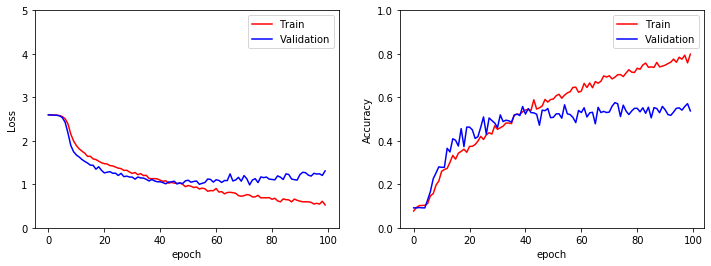

In [21]:
plot_results(res)

Instructions for updating:
Please use Model.predict, which supports generators.
Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.69      0.74      0.71        42
         -30       0.73      0.73      0.73        37
         -45       0.81      0.59      0.69        37
         -60       0.47      0.59      0.52        29
         -75       0.44      0.41      0.43        41
         -90       0.59      0.62      0.61        37
           0       0.74      0.70      0.72        44
          15       0.67      0.45      0.54        31
          30       0.50      0.45      0.48        33
          45       0.48      0.74      0.58        31
          60       0.41      0.28      0.33        25
          75       0.43      0.63      0.51        41
          90       0.52      0.32      0.40        37

    accuracy                           0.57       465
   macro avg       0.57      0.56      0.56       465
weighted avg       0.58 

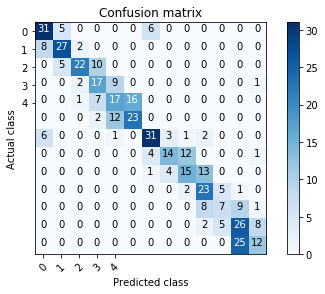

In [22]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model1.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Model 2 - using droput and softmax

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model3 = Sequential()

# input
model3.add(Input(shape=(32, 32, 3)))
model3.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model3.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model3.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))

# Conv Layer 3
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model3.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model3.add(Dense(64))
model3.add(Activation('relu'))
model3.add(Dropout(0.5))
model3.add(Dense(13))
model3.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model3.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')
# Define model


model3.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 13, 13, 32)       

In [24]:
#training the model1
res = train_model(model3, num_epoch=75, verbose=1)

Training epoch 0: Loss = 2.604567527770996, Accuracy = 0.0764627680182457
Validation epoch 0: Loss = 2.596931219100952, Accuracy = 0.09166666865348816
Training epoch 1: Loss = 2.596834182739258, Accuracy = 0.1004500761628151
Validation epoch 1: Loss = 2.5971513191858926, Accuracy = 0.09010416269302368
Training epoch 2: Loss = 2.598175048828125, Accuracy = 0.0992225855588913
Validation epoch 2: Loss = 2.597701291243235, Accuracy = 0.0885416641831398
Training epoch 3: Loss = 2.5956332683563232, Accuracy = 0.09671645611524582
Validation epoch 3: Loss = 2.5958579579989114, Accuracy = 0.09322916716337204
Training epoch 4: Loss = 2.59254789352417, Accuracy = 0.09886456280946732
Validation epoch 4: Loss = 2.595468799273173, Accuracy = 0.09322916716337204
Training epoch 5: Loss = 2.5908443927764893, Accuracy = 0.09886456280946732
Validation epoch 5: Loss = 2.5933932264645896, Accuracy = 0.09010416269302368
Training epoch 6: Loss = 2.5909335613250732, Accuracy = 0.09523322433233261
Validation e

In [25]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

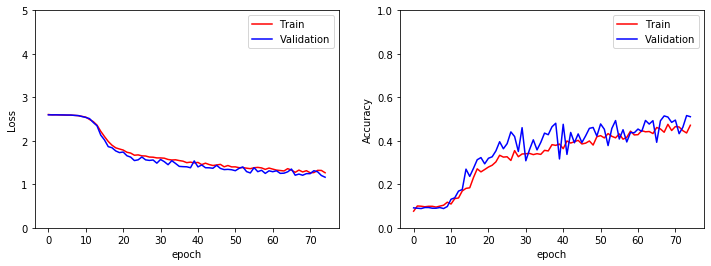

In [26]:
plot_results(res)

Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.82      0.55      0.66        42
         -30       0.60      0.78      0.68        37
         -45       0.67      0.65      0.66        37
         -60       0.46      0.45      0.46        29
         -75       0.36      0.10      0.15        41
         -90       0.54      0.92      0.68        37
           0       0.66      0.95      0.78        44
          15       0.48      0.42      0.45        31
          30       0.36      0.42      0.39        33
          45       0.50      0.52      0.51        31
          60       0.36      0.20      0.26        25
          75       0.35      0.27      0.31        41
          90       0.50      0.59      0.54        37

    accuracy                           0.54       465
   macro avg       0.51      0.52      0.50       465
weighted avg       0.52      0.54      0.51       465



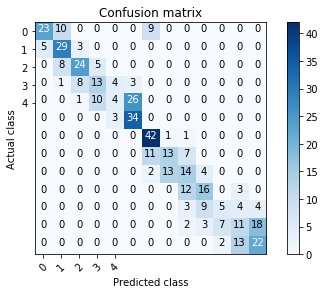

In [27]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model3.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Model 3 - Data Augmentation
It is one of the methods to prevent over fitting

In [28]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_data,
    directory='./modified_data', 
    x_col="filename", 
    y_col="pan", 
    target_size=(32, 32), 
    batch_size=batch_size, 
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory='./modified_data', 
    x_col="filename", 
    y_col="pan", 
    target_size=(32, 32), 
    batch_size=batch_size, 
    class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./modified_data',
        x_col="filename",
        y_col="pan",
        target_size=(32, 32),
        shuffle = False,
        batch_size=batch_size,
        class_mode='categorical')

Found 1488 validated image filenames belonging to 13 classes.
Found 372 validated image filenames belonging to 13 classes.
Found 465 validated image filenames belonging to 13 classes.


In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model3_2 = Sequential()

# input
model3_2.add(Input(shape=(32, 32, 3)))
model3_2.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
model3_2.add(Conv2D(64, (3, 3),))
model3_2.add(Activation('relu'))
model3_2.add(Dropout(0.5))
model3_2.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model3_2.add(Conv2D(64, (3, 3),))
model3_2.add(Activation('relu'))
model3_2.add(Dropout(0.5))

# Conv Layer 3
model3_2.add(Conv2D(128, (3, 3)))
model3_2.add(Activation('relu'))
model3_2.add(Dropout(0.5))
model3_2.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model3_2.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model3_2.add(Dense(128))
model3_2.add(Activation('relu'))
model3_2.add(Dropout(0.5))
model3_2.add(Dense(13))
model3_2.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model3_2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')

model3_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
activation_10 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
activation_11 (Activation)   (None, 13, 13, 64)       

In [30]:
#training the model1
res = train_model(model3_2, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.576894998550415, Accuracy = 0.08938171714544296
Validation epoch 0: Loss = 2.5648234685262046, Accuracy = 0.0885416641831398
Training epoch 1: Loss = 2.565676212310791, Accuracy = 0.08602150529623032
Validation epoch 1: Loss = 2.56540913383166, Accuracy = 0.0885416641831398
Training epoch 2: Loss = 2.5643107891082764, Accuracy = 0.09879032522439957
Validation epoch 2: Loss = 2.5663859645525613, Accuracy = 0.0885416641831398
Training epoch 3: Loss = 2.5647706985473633, Accuracy = 0.09825268387794495
Validation epoch 3: Loss = 2.5674525698026023, Accuracy = 0.0885416641831398
Training epoch 4: Loss = 2.563567638397217, Accuracy = 0.09838709235191345
Validation epoch 4: Loss = 2.5667014718055725, Accuracy = 0.0885416641831398
Training epoch 5: Loss = 2.5650131702423096, Accuracy = 0.09879032522439957
Validation epoch 5: Loss = 2.5672620137532554, Accuracy = 0.0885416641831398
Training epoch 6: Loss = 2.5641095638275146, Accuracy = 0.09879032522439957
Validation 

In [31]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

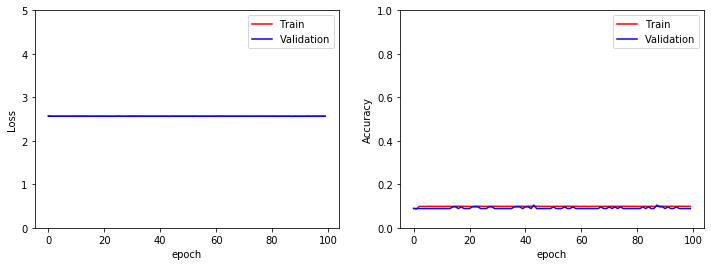

In [32]:
plot_results(res)

Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.00      0.00      0.00        42
         -30       0.00      0.00      0.00        37
         -45       0.00      0.00      0.00        37
         -60       0.00      0.00      0.00        29
         -75       0.00      0.00      0.00        41
         -90       0.00      0.00      0.00        37
           0       0.09      1.00      0.17        44
          15       0.00      0.00      0.00        31
          30       0.00      0.00      0.00        33
          45       0.00      0.00      0.00        31
          60       0.00      0.00      0.00        25
          75       0.00      0.00      0.00        41
          90       0.00      0.00      0.00        37

    accuracy                           0.09       465
   macro avg       0.01      0.08      0.01       465
weighted avg       0.01      0.09      0.02       465



/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


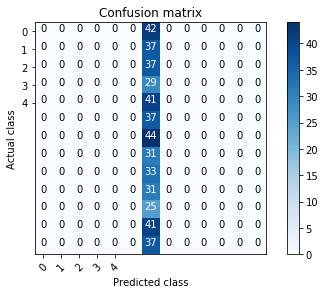

In [33]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model3_2.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


In [34]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
    dataframe=training_data,
    directory='./modified_data', 
    x_col="filename", 
    y_col="pan", 
    target_size=(32, 32), 
    batch_size=batch_size, 
    class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=validation_data,
    directory='./modified_data', 
    x_col="filename", 
    y_col="pan", 
    target_size=(32, 32), 
    batch_size=batch_size, 
    class_mode='categorical')

test_generator = val_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./modified_data',
        x_col="filename",
        y_col="pan",
        target_size=(32, 32),
        shuffle = False,
        batch_size=batch_size,
        class_mode='categorical')

Found 1488 validated image filenames belonging to 13 classes.
Found 372 validated image filenames belonging to 13 classes.
Found 465 validated image filenames belonging to 13 classes.


## Model 4 
Adding more layers since the function under consideration is fairly complex in nature.

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model8 = Sequential()

# input
model8.add(Input(shape=(32, 32, 3)))
model8.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
model8.add(Conv2D(64, (3, 3),))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))
model8.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model8.add(Conv2D(64, (3, 3),))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))

# Conv Layer 3
model8.add(Conv2D(128, (3, 3)))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))
model8.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model8.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model8.add(Dense(128))
model8.add(Activation('relu'))
model8.add(Dropout(0.5))
model8.add(Dense(13))
model8.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model8.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')

model8.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_3 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 30, 30, 64)        640       
_________________________________________________________________
activation_15 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
activation_16 (Activation)   (None, 13, 13, 64)       

In [36]:
#training the model1
res = train_model(model8, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.5779757499694824, Accuracy = 0.08131720125675201
Validation epoch 0: Loss = 2.5661321381727853, Accuracy = 0.0885416641831398
Training epoch 1: Loss = 2.5659983158111572, Accuracy = 0.09865591675043106
Validation epoch 1: Loss = 2.5671799977620444, Accuracy = 0.0885416641831398
Training epoch 2: Loss = 2.562979221343994, Accuracy = 0.10282257944345474
Validation epoch 2: Loss = 2.5670072933038077, Accuracy = 0.0885416641831398
Training epoch 3: Loss = 2.565086603164673, Accuracy = 0.09798387438058853
Validation epoch 3: Loss = 2.5614421665668488, Accuracy = 0.1119791641831398
Training epoch 4: Loss = 2.565095901489258, Accuracy = 0.10013440996408463
Validation epoch 4: Loss = 2.5657071073849997, Accuracy = 0.0885416641831398
Training epoch 5: Loss = 2.5644407272338867, Accuracy = 0.09865591675043106
Validation epoch 5: Loss = 2.5682592391967773, Accuracy = 0.0885416641831398
Training epoch 6: Loss = 2.5642004013061523, Accuracy = 0.09865591675043106
Validatio

In [37]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

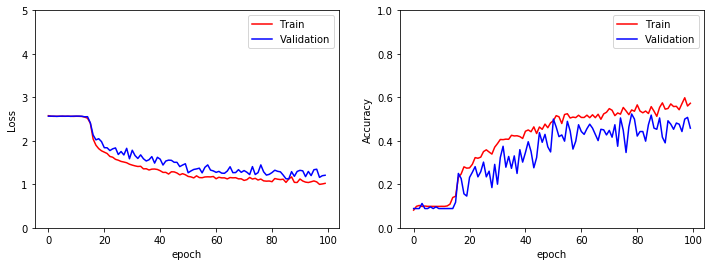

In [38]:
plot_results(res)

Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.70      0.55      0.61        42
         -30       0.67      0.65      0.66        37
         -45       0.67      0.65      0.66        37
         -60       0.30      0.66      0.41        29
         -75       0.35      0.15      0.21        41
         -90       0.88      0.41      0.56        37
           0       0.53      0.93      0.67        44
          15       0.47      0.58      0.52        31
          30       0.29      0.12      0.17        33
          45       0.40      0.61      0.49        31
          60       0.14      0.04      0.06        25
          75       0.36      0.46      0.40        41
          90       0.52      0.35      0.42        37

    accuracy                           0.49       465
   macro avg       0.48      0.47      0.45       465
weighted avg       0.50      0.49      0.46       465



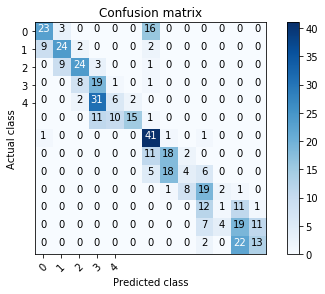

In [39]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model8.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Model 5 
Using Dropout and sigmoid activation function with just one hidden layer

In [40]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Input
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.metrics import categorical_accuracy

# Input layer
input_ = Input(shape=(32, 32, 3)) # This is the input shape
input_slice = Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))(input_)
x = Flatten()(input_slice)  # This will convert the 28x28 input to a vector of  dimension 784

# Hidden layer
h = Dense(64)(x)
h = Activation('sigmoid')(h)
h= Dropout(rate=0.5)(h)

# Output layer
out_ = Dense(13)(h)
out_ = Activation('softmax')(out_)

# Define model
model_orig2 = Model(inputs=input_, outputs=out_)

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_orig2.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

model_orig2.summary()
# Creating a model for feature vizualization 
hidden_features2 = Model(inputs=input_, outputs=h)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
lambda_4 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                65600     
_________________________________________________________________
activation_20 (Activation)   (None, 64)                0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 13)                845   

In [41]:
#training the model12
res = train_model(model_orig2, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.6177310943603516, Accuracy = 0.0880376324057579
Validation epoch 0: Loss = 2.5559052427609763, Accuracy = 0.0885416641831398
Training epoch 1: Loss = 2.558340549468994, Accuracy = 0.08709678053855896
Validation epoch 1: Loss = 2.5523997048536935, Accuracy = 0.0963541641831398
Training epoch 2: Loss = 2.555743932723999, Accuracy = 0.09784946590662003
Validation epoch 2: Loss = 2.5420168240865073, Accuracy = 0.1223958358168602
Training epoch 3: Loss = 2.546914577484131, Accuracy = 0.10860215127468109
Validation epoch 3: Loss = 2.541334559520086, Accuracy = 0.0963541641831398
Training epoch 4: Loss = 2.5348639488220215, Accuracy = 0.11397849768400192
Validation epoch 4: Loss = 2.522288421789805, Accuracy = 0.1276041716337204
Training epoch 5: Loss = 2.5253067016601562, Accuracy = 0.12661290168762207
Validation epoch 5: Loss = 2.4986607432365417, Accuracy = 0.140625
Training epoch 6: Loss = 2.5124173164367676, Accuracy = 0.12083333730697632
Validation epoch 6: Lo

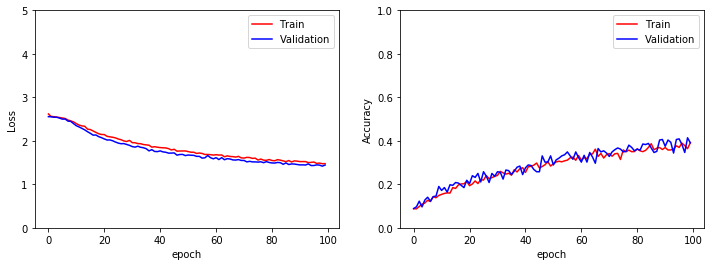

In [42]:
plot_results(res)

Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.48      0.26      0.34        42
         -30       0.51      0.49      0.50        37
         -45       0.54      0.70      0.61        37
         -60       0.31      0.48      0.38        29
         -75       0.42      0.20      0.27        41
         -90       0.45      0.59      0.51        37
           0       0.42      0.61      0.50        44
          15       0.40      0.06      0.11        31
          30       0.46      0.39      0.43        33
          45       0.42      0.55      0.48        31
          60       0.25      0.24      0.24        25
          75       0.46      0.39      0.42        41
          90       0.39      0.51      0.44        37

    accuracy                           0.43       465
   macro avg       0.42      0.42      0.40       465
weighted avg       0.43      0.43      0.41       465



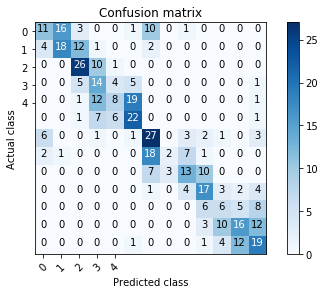

In [43]:
#  confusion matrix 
#Note, this code is taken straight from the SKLEARN website.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_orig2.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))

## Model 6
The CNN model is used since weights to be calculated is huge and here we use the 5*5 sizes and variations are produced in all the four major building blocks of CNN.

In [44]:
#model with 5x5 filter size
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_6 = Sequential()

# input
model_6.add(Input(shape=(32, 32, 3)))

model_6.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_6.add(Conv2D(32, (5, 5)))
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 
model_6.add(Conv2D(64, (3, 3)))
model_6.add(Activation('relu'))
model_6.add(MaxPooling2D(pool_size=(2, 2)))


# MLP
model_6.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_6.add(Dense(64))
model_6.add(Activation('relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(13))
model_6.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_6.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
model_6.save_weights('model.h6')

model_6.summary()
model_6.load_weights('model.h6')
res = train_model(model_6, num_epoch=100, verbose=1)


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 28, 28, 32)        832       
_________________________________________________________________
activation_22 (Activation)   (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 12, 12, 64)        18496     
_________________________________________________________________
activation_23 (Activation)   (None, 12, 12, 64)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 6, 6, 64)         

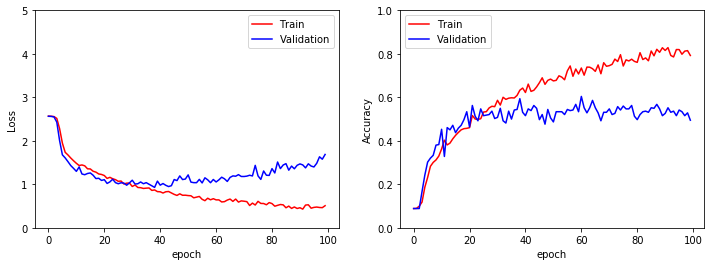

In [45]:
plot_results(res)

Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.84      0.50      0.63        42
         -30       0.64      0.68      0.66        37
         -45       0.76      0.59      0.67        37
         -60       0.45      0.59      0.51        29
         -75       0.31      0.37      0.34        41
         -90       0.42      0.35      0.38        37
           0       0.59      0.73      0.65        44
          15       0.62      0.65      0.63        31
          30       0.49      0.52      0.50        33
          45       0.39      0.42      0.41        31
          60       0.35      0.24      0.29        25
          75       0.40      0.49      0.44        41
          90       0.53      0.49      0.51        37

    accuracy                           0.51       465
   macro avg       0.52      0.51      0.51       465
weighted avg       0.53      0.51      0.51       465



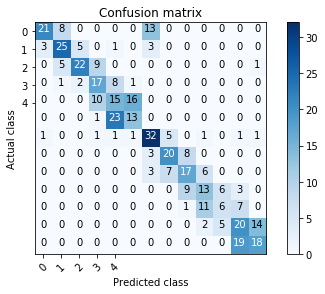

In [46]:
#  confusion matrix 
#Note, this code is taken straight from the SKLEARN website.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_6.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))

## Model 7 - using adam optimiser 

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_7 = Sequential()

# input
model_7.add(Input(shape=(32, 32, 3)))
model_7.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
model_7.add(Conv2D(64, (3, 3),))
model_7.add(Activation('relu'))
model_7.add(Dropout(0.5))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model_7.add(Conv2D(64, (3, 3),))
model_7.add(Activation('relu'))
model_7.add(Dropout(0.5))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 3
model_7.add(Conv2D(128, (3, 3)))
model_7.add(Activation('relu'))
model_7.add(Dropout(0.5))
model_7.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model_7.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_7.add(Dense(128))
model_7.add(Activation('relu'))
model_7.add(Dropout(0.5))
model_7.add(Dense(13))
model_7.add(Activation('softmax'))

adam = optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
model_7.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')

model_7.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 30, 30, 64)        640       
_________________________________________________________________
activation_26 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 13, 13, 64)        36928     
_________________________________________________________________
activation_27 (Activation)   (None, 13, 13, 64)       

In [48]:
#training the model1
res = train_model(model_7, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.579221248626709, Accuracy = 0.09206989407539368
Validation epoch 0: Loss = 2.564862738053004, Accuracy = 0.0885416641831398
Training epoch 1: Loss = 2.559358596801758, Accuracy = 0.0927419364452362
Validation epoch 1: Loss = 2.5489676892757416, Accuracy = 0.1015625
Training epoch 2: Loss = 2.2952656745910645, Accuracy = 0.16048386693000793
Validation epoch 2: Loss = 2.1613933642705283, Accuracy = 0.2526041567325592
Training epoch 3: Loss = 1.9198204278945923, Accuracy = 0.2521505355834961
Validation epoch 3: Loss = 2.034625137845675, Accuracy = 0.3020833432674408
Training epoch 4: Loss = 1.7931193113327026, Accuracy = 0.2663978338241577
Validation epoch 4: Loss = 1.9891480753819148, Accuracy = 0.3307291567325592
Training epoch 5: Loss = 1.6930909156799316, Accuracy = 0.2938172221183777
Validation epoch 5: Loss = 1.9227168063322704, Accuracy = 0.3307291567325592
Training epoch 6: Loss = 1.610467553138733, Accuracy = 0.3211021423339844
Validation epoch 6: Loss 

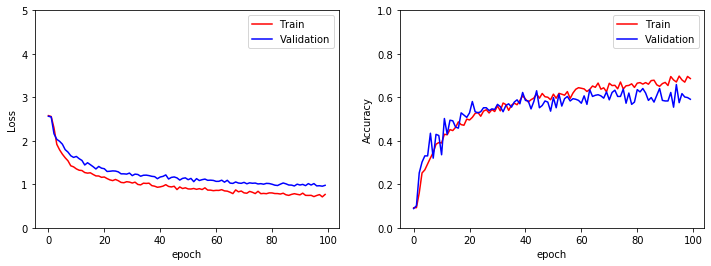

In [49]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])
plot_results(res)

Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.81      0.69      0.74        42
         -30       0.67      0.86      0.75        37
         -45       0.82      0.62      0.71        37
         -60       0.65      0.69      0.67        29
         -75       0.46      0.39      0.42        41
         -90       0.55      0.57      0.56        37
           0       0.63      0.93      0.75        44
          15       0.61      0.45      0.52        31
          30       0.56      0.42      0.48        33
          45       0.49      0.55      0.52        31
          60       0.32      0.44      0.37        25
          75       0.34      0.29      0.32        41
          90       0.53      0.46      0.49        37

    accuracy                           0.57       465
   macro avg       0.57      0.57      0.56       465
weighted avg       0.58      0.57      0.57       465



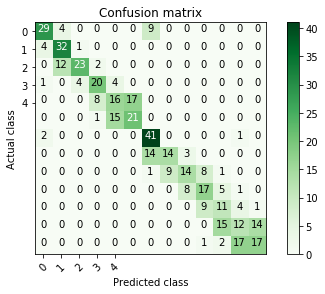

In [50]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_7.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Model 8

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_8 = Sequential()

# input
model_8.add(Input(shape=(32, 32, 3)))
model_8.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
model_8.add(Conv2D(32, (3, 3),))
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model_8.add(Conv2D(32, (3, 3),))
model_8.add(Activation('relu'))

# Conv Layer 3
model_8.add(Conv2D(64, (3, 3)))
model_8.add(Activation('relu'))
model_8.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 4
model_8.add(Conv2D(64, (3, 3)))
model_8.add(Activation('relu'))
model_8.add(Dropout(0.5))

# MLP
model_8.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_8.add(Dense(128))
model_8.add(Activation('relu'))
model_8.add(Dense(128))
model_8.add(Activation('relu'))
model_8.add(Dropout(0.5))
model_8.add(Dense(13))
model_8.add(Activation('softmax'))

adam = optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
model_8.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')

model_8.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_7 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
activation_31 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_32 (Activation)   (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 11, 11, 64)       

In [ ]:
#training the model1
res = train_model(model_8, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.5674703121185303, Accuracy = 0.08266129344701767
Validation epoch 0: Loss = 2.563523848851522, Accuracy = 0.0885416641831398
Training epoch 1: Loss = 2.563704013824463, Accuracy = 0.09529569745063782
Validation epoch 1: Loss = 2.56351438164711, Accuracy = 0.0885416641831398
Training epoch 2: Loss = 2.5111241340637207, Accuracy = 0.1111559122800827
Validation epoch 2: Loss = 2.174214243888855, Accuracy = 0.1666666716337204
Training epoch 3: Loss = 2.0586886405944824, Accuracy = 0.2081989198923111
Validation epoch 3: Loss = 1.709386055668195, Accuracy = 0.28125
Training epoch 4: Loss = 1.814496397972107, Accuracy = 0.26532256603240967
Validation epoch 4: Loss = 1.597448433438937, Accuracy = 0.359375
Training epoch 5: Loss = 1.6817671060562134, Accuracy = 0.30456990003585815
Validation epoch 5: Loss = 1.5167088160912197, Accuracy = 0.3515625
Training epoch 6: Loss = 1.5611894130706787, Accuracy = 0.33790323138237
Validation epoch 6: Loss = 1.369699090719223, Acc

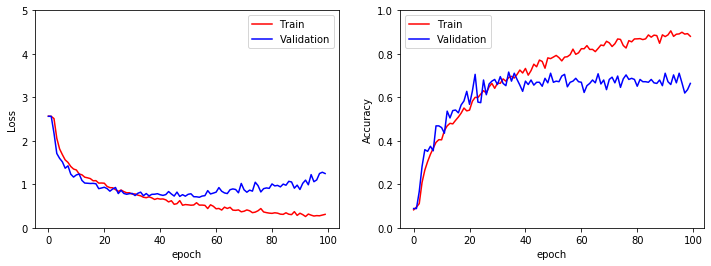

In [ ]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])
plot_results(res)

Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.74      0.74      0.74        42
         -30       0.80      0.65      0.72        37
         -45       0.86      0.84      0.85        37
         -60       0.73      0.76      0.75        29
         -75       0.66      0.51      0.58        41
         -90       0.64      0.76      0.69        37
           0       0.73      0.91      0.81        44
          15       0.82      0.74      0.78        31
          30       0.73      0.58      0.64        33
          45       0.57      0.68      0.62        31
          60       0.44      0.64      0.52        25
          75       0.44      0.41      0.43        41
          90       0.70      0.57      0.63        37

    accuracy                           0.68       465
   macro avg       0.68      0.68      0.67       465
weighted avg       0.68      0.68      0.67       465



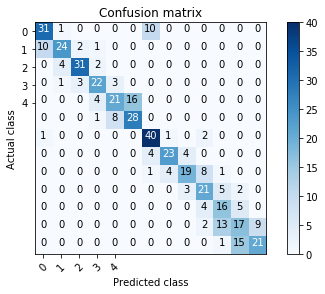

In [ ]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_8.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Model 9

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_9 = Sequential()

# input
model_9.add(Input(shape=(32, 32, 3)))
model_9.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 

# Conv Layer 1
model_9.add(Conv2D(32, (3, 3),))
model_9.add(Activation('relu'))
model_9.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model_9.add(Conv2D(32, (3, 3),))
model_9.add(Activation('relu'))


# Conv Layer 3
model_9.add(Conv2D(64, (3, 3)))
model_9.add(Activation('relu'))
model_9.add(MaxPooling2D(pool_size=(2, 2)))
model_9.add(Dropout(0.5))

# Conv Layer 4
model_9.add(Conv2D(64, (3, 3)))
model_9.add(Activation('relu'))
model_9.add(Dropout(0.5))

# MLP
model_9.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_9.add(Dense(128))
model_9.add(Activation('relu'))
model_9.add(Dense(128))
model_9.add(Activation('relu'))
model_9.add(Dropout(0.5))
model_9.add(Dense(13))
model_9.add(Activation('softmax'))

adam = optimizers.Adam(learning_rate=0.001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
model_9.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
# model_cnn.save_weights('model.h5')

model_9.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_8 (Lambda)            (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 30, 30, 32)        320       
_________________________________________________________________
activation_38 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 13, 13, 32)        9248      
_________________________________________________________________
activation_39 (Activation)   (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 11, 11, 64)       

In [ ]:
#training the model1
res = train_model(model_9, num_epoch=100, verbose=1)

Training epoch 0: Loss = 2.5667617321014404, Accuracy = 0.07997311651706696
Validation epoch 0: Loss = 2.5646992127100625, Accuracy = 0.0885416641831398
Training epoch 1: Loss = 2.564652919769287, Accuracy = 0.09865591675043106
Validation epoch 1: Loss = 2.5640282233556113, Accuracy = 0.0963541641831398
Training epoch 2: Loss = 2.561997652053833, Accuracy = 0.09529569745063782
Validation epoch 2: Loss = 2.5416743556658425, Accuracy = 0.1041666641831398
Training epoch 3: Loss = 2.37355375289917, Accuracy = 0.12446236610412598
Validation epoch 3: Loss = 1.9854877789815266, Accuracy = 0.2005208283662796
Training epoch 4: Loss = 2.0157601833343506, Accuracy = 0.20739248394966125
Validation epoch 4: Loss = 1.762674167752266, Accuracy = 0.2864583432674408
Training epoch 5: Loss = 1.8042579889297485, Accuracy = 0.27419355511665344
Validation epoch 5: Loss = 1.6107677966356277, Accuracy = 0.3307291567325592
Training epoch 6: Loss = 1.6840379238128662, Accuracy = 0.3034946322441101
Validation e

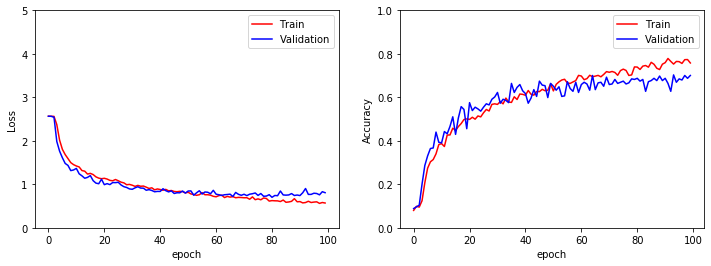

In [ ]:
#plot the results and plot the error loss for the training and accuracy data
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])
plot_results(res)

Prediction shape is (465, 13)
              precision    recall  f1-score   support

         -15       0.85      0.69      0.76        42
         -30       0.76      0.86      0.81        37
         -45       0.89      0.84      0.86        37
         -60       0.56      0.86      0.68        29
         -75       0.47      0.51      0.49        41
         -90       0.71      0.41      0.52        37
           0       0.85      0.75      0.80        44
          15       0.62      0.81      0.70        31
          30       0.71      0.61      0.66        33
          45       0.76      0.61      0.68        31
          60       0.53      0.80      0.63        25
          75       0.59      0.39      0.47        41
          90       0.61      0.76      0.67        37

    accuracy                           0.68       465
   macro avg       0.69      0.68      0.67       465
weighted avg       0.69      0.68      0.67       465



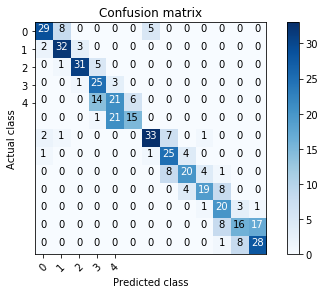

In [ ]:
#confusion matrix 
#Note, this code is taken straight from the SKLEARN website
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual class')
    plt.xlabel('Predicted class')


from collections import Counter
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

predictions = model_9.predict_generator(test_generator,verbose=0)
print("Prediction shape is", predictions.shape)

predictedLabels =[]
for i in range(0,len(predictions[:,0])):
    predictedLabels.append(np.argmax(predictions[i]))

#predictedLabels = np.asarray(predictedLabels)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

report = metrics.classification_report(true_classes, predictedLabels, target_names=class_labels)
print(report)
confusion_mtx = confusion_matrix(true_classes, predictedLabels)
plot_confusion_matrix(confusion_mtx, classes = range(5))


## Prediction

In [ ]:
df = pd.read_csv('test_data.csv')
headpose_data
df.head()

,filename,person_id,series
0,face_33.jpg,2,1
1,face_2148.jpg,2,2
2,face_2119.jpg,2,1
3,face_1262.jpg,2,1
4,face_516.jpg,2,2


In [ ]:
dfv2 = pd.merge(df,headpose_data, on='filename')
dfv2.head()

,filename,person_id,series,image_path
0,face_33.jpg,2,1,modified_data/face_33.jpg
1,face_2148.jpg,2,2,modified_data/face_2148.jpg
2,face_2119.jpg,2,1,modified_data/face_2119.jpg
3,face_1262.jpg,2,1,modified_data/face_1262.jpg
4,face_516.jpg,2,2,modified_data/face_516.jpg


In [ ]:
submission_df1 = dfv2[['filename','image_path']]

In [ ]:
new_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

new_generator = new_datagen.flow_from_dataframe(
    dataframe=submission_df1,
    directory='./modified_data', 
    x_col="filename", 
    y_col="image_path", 
    target_size=(32, 32), 
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')


Found 465 validated image filenames belonging to 465 classes.


In [ ]:
y_pred = model_9.predict_generator(new_generator,verbose=1)
print("Test dataset shape", y_pred.shape)

Y_pred_labels =[]
for i in range(0,len(y_pred[:,0])):
    Y_pred_labels.append(np.argmax(predictions[i]))

Y_pred_labels = np.asarray(Y_pred_labels)

30/30 [==============================] - 1s 22ms/step
Test dataset shape (465, 13)


In [ ]:
for image, x in enumerate(Y_pred_labels):
    if x == 0:
        predictedLabels[image] = -15
    elif x == 1:
        predictedLabels[image] = -30
    elif x == 2:
        predictedLabels[image] = -45
    elif x == 3:
        predictedLabels[image] = -60
    elif x == 4:
        predictedLabels[image] = -75
    elif x == 5:
        predictedLabels[image] = -90
    elif x == 6:
        predictedLabels[image] = 0
    elif x == 7:
        predictedLabels[image] = 15
    elif x == 8:
        predictedLabels[image] = 30
    elif x == 9:
        predictedLabels[image] = 45
    elif x == 10:
        predictedLabels[image] = 60
    elif x == 11:
        predictedLabels[image] = 75
    else: 
        predictedLabels[image] = 90

In [ ]:
import pandas as pd
df = pd.DataFrame(predictedLabels, columns=["pan"])
result = pd.concat([submission_df1['filename'],df], axis=1, sort=False)

In [ ]:
result.head()

,filename,pan
0,face_33.jpg,-60
1,face_2148.jpg,60
2,face_2119.jpg,60
3,face_1262.jpg,-15
4,face_516.jpg,-75


In [ ]:
result.to_csv('s3763905_pan_predictions.csv', index=False)

In [ ]:
tilt_pred = pd.read_csv('s3763905_tilt_predictions.csv')
tilt_pred.head()

,filename,tilt
0,face_33.jpg,30
1,face_2148.jpg,30
2,face_2119.jpg,15
3,face_1262.jpg,-15
4,face_516.jpg,-30


In [ ]:
pan_pred = pd.read_csv('s3763905_pan_predictions.csv')
pan_pred.head()

,filename,pan
0,face_33.jpg,-60
1,face_2148.jpg,60
2,face_2119.jpg,60
3,face_1262.jpg,-15
4,face_516.jpg,-75


In [ ]:
merged_prediction = pd.merge(tilt_pred,pan_pred, on='filename')
merged_prediction.head()

,filename,tilt,pan
0,face_33.jpg,30,-60
1,face_2148.jpg,30,60
2,face_2119.jpg,15,60
3,face_1262.jpg,-15,-15
4,face_516.jpg,-30,-75


In [ ]:
merged_prediction.to_csv('s3763905_predictions.csv', index=False)